# Environment

In [10]:
%%capture
!git clone https://github.com/cuongtv312/marl-delivery.git marl_delivery

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [1]:
from env import Environment
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import random
import os
from sklearn.calibration import LabelEncoder



SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
device

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


device(type='cuda')

In [2]:
import numpy as np

def convert_state(state, persistent_packages, current_robot_idx=None):
    """
    Convert state to a 2D multi-channel tensor.
    - If current_robot_idx is not None: 8 channels (robot-specific obs)
    - If current_robot_idx is None: 6 channels (global state)
    Returns:
        np.ndarray of shape (n_channels, n_rows, n_cols)
    """
    grid = np.array(state["map"])
    n_rows, n_cols = grid.shape
    n_channels = 8 if current_robot_idx is not None else 6
    tensor = np.zeros((n_channels, n_rows, n_cols), dtype=np.float32)

    # 0. Map channel
    tensor[0] = grid

    # 1. Urgency channel - uses persistent_packages (for 'waiting' packages at their start location)
    current_time_step = state["time_step"][0] if isinstance(state["time_step"], np.ndarray) else state["time_step"]
    for pkg_id, pkg_data in persistent_packages.items():
        if pkg_data['status'] == 'waiting':
            sr, sc = pkg_data['start_pos'] # 0-indexed
            st = pkg_data['start_time']
            dl = pkg_data['deadline']
            urgency = max(0, min(1, (current_time_step - st) / (dl - st))) if dl > st else 0
            if 0 <= sr < n_rows and 0 <= sc < n_cols: # Boundary check
                tensor[1, sr, sc] = urgency

    # 2. Start position channel - uses persistent_packages (presence of 'waiting' packages)
    for pkg_id, pkg_data in persistent_packages.items():
        if pkg_data['status'] == 'waiting':
            sr, sc = pkg_data['start_pos'] # 0-indexed
            if 0 <= sr < n_rows and 0 <= sc < n_cols: # Boundary check
                tensor[2, sr, sc] = 1.0 # Mark presence

    # 3. Target position channel - uses persistent_packages (presence of 'waiting' or 'in_transit' package targets)
    for pkg_id, pkg_data in persistent_packages.items():
        if pkg_data['status'] in ['waiting', 'in_transit']:
            tr, tc = pkg_data['target_pos'] # 0-indexed
            if 0 <= tr < n_rows and 0 <= tc < n_cols: # Boundary check
                tensor[3, tr, tc] = 1.0 # Mark presence

    # 4. Robot carrying channel - uses state["robots"] (presence of any robot carrying a package)
    # state["robots"] provides (pos_x+1, pos_y+1, carrying_package_id) - 1-indexed
    for rob_idx, rob in enumerate(state["robots"]):
        rr, rc, carrying_pkg_id = rob
        rr_idx, rc_idx = int(rr)-1, int(rc)-1 # Convert to 0-indexed for tensor
        if carrying_pkg_id != 0: # If carrying a package
            if 0 <= rr_idx < n_rows and 0 <= rc_idx < n_cols: # Boundary check
                tensor[4, rr_idx, rc_idx] = 1.0 # Mark presence

    # 5. Robots' positions channel
    if current_robot_idx is not None: # Robot-specific: Other robots' positions
        for i, rob in enumerate(state["robots"]):
            if i != current_robot_idx:
                rr, rc, _ = rob
                rr_idx, rc_idx = int(rr)-1, int(rc)-1 # 0-indexed
                if 0 <= rr_idx < n_rows and 0 <= rc_idx < n_cols: # Boundary check
                    tensor[5, rr_idx, rc_idx] = 1.0
    else: # Global state: all robots' positions
        for rob in state["robots"]:
            rr, rc, _ = rob
            rr_idx, rc_idx = int(rr)-1, int(rc)-1 # 0-indexed
            if 0 <= rr_idx < n_rows and 0 <= rc_idx < n_cols: # Boundary check
                tensor[5, rr_idx, rc_idx] = 1.0

    # --- Robot-specific channels (if current_robot_idx is not None) ---
    if current_robot_idx is not None:
        # 6. Current robot's position channel
        rob = state["robots"][current_robot_idx]
        rr, rc, _ = rob
        rr_idx, rc_idx = int(rr)-1, int(rc)-1 # 0-indexed
        if 0 <= rr_idx < n_rows and 0 <= rc_idx < n_cols: # Boundary check
            tensor[6, rr_idx, rc_idx] = 1.0

        # 7. Current Robot's Carried Package Target Position channel
        current_robot_data = state["robots"][current_robot_idx]
        carried_pkg_id_by_current_robot = current_robot_data[2] # 1-indexed ID, 0 if not carrying

        if carried_pkg_id_by_current_robot != 0:
            # Ensure the package ID from state['robots'] is valid and exists in persistent_packages
            if carried_pkg_id_by_current_robot in persistent_packages:
                pkg_data_carried = persistent_packages[carried_pkg_id_by_current_robot]
                if pkg_data_carried['status'] == 'in_transit': # Make sure it's indeed in transit
                    tr_carried, tc_carried = pkg_data_carried['target_pos'] # 0-indexed
                    if 0 <= tr_carried < n_rows and 0 <= tc_carried < n_cols: # Boundary check
                        tensor[7, tr_carried, tc_carried] = 1.0
            # else:
                # This case might indicate an inconsistency if a robot is carrying an ID
                # not in persistent_packages. Should be handled by _update_persistent_packages.
                # print(f"Warning: Robot {current_robot_idx} carrying pkg {carried_pkg_id_by_current_robot} not in persistent_packages.")


    return tensor

# Agent Network

In [3]:
class AgentNetwork(nn.Module):
    def __init__(self, observation_shape, action_dim):
        super(AgentNetwork, self).__init__()
        # observation_shape is (C, H, W)
        self.conv1 = nn.Conv2d(observation_shape[0], 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        flat_size = 32 * observation_shape[1] * observation_shape[2]  # 32 * H * W

        self.fc1 = nn.Linear(flat_size, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, obs):
        # obs: (N, C, H, W) or (C, H, W)
        if obs.dim() == 3:
            obs = obs.unsqueeze(0)  # (1, C, H, W)
        x = F.relu(self.bn1(self.conv1(obs)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.flatten(start_dim=1)  # (N, 32*H*W)
        x = F.relu(self.fc1(x))
        q_values = self.fc2(x)
        return q_values

# HyperNetwork

In [4]:
class HyperNetwork(nn.Module):
    def __init__(self, input_shape, output_dim, hidden_dim):
        super().__init__()
        # input_shape: (C, H, W)
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        flat_size = 16 * input_shape[1] * input_shape[2]
        self.fc1 = nn.Linear(flat_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, state):
        # state: (B, C, H, W) or (C, H, W)
        if state.dim() == 3:
            state = state.unsqueeze(0)  # (1, C, H, W)
        x = state  # (B, C, H, W)
        x = F.relu(self.bn1(self.conv1(x)))  # (B, 32, H, W)
        x = F.relu(self.bn2(self.conv2(x)))  # (B, 16, H, W)
        x = x.flatten(start_dim=1)  # (B, 16*H*W)
        x = F.relu(self.fc1(x))     # (B, hidden_dim)
        weights = self.fc2(x)       # (B, output_dim)
        return weights

# Mixing Network

In [5]:
class MixingNetwork(nn.Module):
    def __init__(self, state_dim, num_agents, mixing_dim):
        super(MixingNetwork, self).__init__()
        self.num_agents = num_agents
        self.mixing_dim = mixing_dim

        # state_dim: (C, H, W)
        self.hyper_w1 = HyperNetwork(state_dim, num_agents * mixing_dim, 64)
        self.hyper_b1 = HyperNetwork(state_dim, mixing_dim, 64)
        self.hyper_w2 = HyperNetwork(state_dim, mixing_dim, 64)
        self.hyper_b2 = HyperNetwork(state_dim, 1, 64)

        # Add batch normalization for state input
        self.bn = nn.BatchNorm2d(state_dim[0])

    def forward(self, agent_qs, states):
        # agent_qs: (B, num_agents) or (num_agents,)
        # states: (B, C, H, W) or (C, H, W)

        # Ensure batch dimension for agent_qs
        if agent_qs.dim() == 1:
            agent_qs = agent_qs.unsqueeze(0)  # (1, num_agents)

        batch_size = agent_qs.size(0)

        # Ensure batch dimension for states
        if states.dim() == 3:
            states = states.unsqueeze(0)  # (1, C, H, W)

        # Apply batch normalization to state input
        states = self.bn(states)

        # agent_qs: (B, num_agents) -> (B, 1, num_agents)
        agent_qs = agent_qs.view(batch_size, 1, self.num_agents)

        # First layer weights and biases
        w1 = torch.abs(self.hyper_w1(states))  # (B, num_agents * mixing_dim)
        w1 = w1.view(batch_size, self.num_agents, self.mixing_dim)  # (B, num_agents, mixing_dim)
        b1 = self.hyper_b1(states)  # (B, mixing_dim)
        b1 = b1.view(batch_size, 1, self.mixing_dim)  # (B, 1, mixing_dim)

        # Compute first layer output
        hidden = F.elu(torch.bmm(agent_qs, w1) + b1)  # (B, 1, mixing_dim)

        # Second layer weights and biases
        w2 = torch.abs(self.hyper_w2(states))  # (B, mixing_dim)
        w2 = w2.view(batch_size, self.mixing_dim, 1)  # (B, mixing_dim, 1)
        b2 = self.hyper_b2(states)  # (B, 1)
        b2 = b2.view(batch_size, 1, 1)  # (B, 1, 1)

        # Compute final output
        q_tot = torch.bmm(hidden, w2) + b2  # (B, 1, 1)
        q_tot = q_tot.squeeze(-1).squeeze(-1)  # (B,)

        return q_tot

# Hyperparameters

In [17]:
ACTION_DIM = 15
NUM_AGENTS = 5
MAP_FILE = "map1.txt"
N_PACKAGES = 20

# Normalize reward
MOVE_COST = -0.01 / 100.0
DELIVERY_REWARD = 100 / 100.0
DELAY_REWARD = 10 / 100.0

MAX_TIME_STEPS = 200
MIXING_DIM = 32
NUM_EPISODES = 500
BATCH_SIZE = 32
GAMMA = 0.99
LR = 5e-5
WEIGHT_DECAY = 1e-4
MAX_REPLAY_BUFFER_SIZE = 10000
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 500
TAU = 0.01
GRADIENT_CLIPPING = 0.1

# Replay Buffer

In [18]:
import numpy as np
import torch

class ReplayBuffer:
    def __init__(self, capacity, num_agents, obs_shape, state_shape, device="cpu"):
        self.capacity = capacity
        self.num_agents = num_agents
        self.obs_shape = obs_shape  
        self.state_shape = state_shape 
        self.device = device

        # Determine actual shapes for numpy arrays
        _obs_s = (obs_shape,) if isinstance(obs_shape, int) else obs_shape
        _state_s = (state_shape,) if isinstance(state_shape, int) else state_shape

        self.states = np.zeros((capacity, *_state_s), dtype=np.float32)
        self.observations = np.zeros((capacity, num_agents, *_obs_s), dtype=np.float32)
        self.actions = np.zeros((capacity, num_agents), dtype=np.int64)
        self.total_reward = np.zeros((capacity, 1), dtype=np.float32) # Global reward
        self.next_states = np.zeros((capacity, *_state_s), dtype=np.float32)
        self.next_observations = np.zeros((capacity, num_agents, *_obs_s), dtype=np.float32)
        self.dones = np.zeros((capacity, 1), dtype=np.bool_) # Global done flag

        self.ptr = 0
        self.size = 0

    def add(self, state, next_state, obs, next_obs, actions, total_reward, done):
        """
        Adds a transition to the buffer.
        - state: np.array with shape self.state_shape
        - obs: np.array with shape (self.num_agents, *self.obs_shape)
        - actions: np.array with shape (self.num_agents,)
        - total_reward: float or np.array shape (1,) (global reward)
        - next_state: np.array with shape self.state_shape
        - next_obs: np.array with shape (self.num_agents, *self.obs_shape)
        - done: bool or np.array shape (1,) (global done flag)
        """
        self.states[self.ptr] = state
        self.observations[self.ptr] = obs
        self.actions[self.ptr] = actions
        self.total_reward[self.ptr] = total_reward
        self.next_states[self.ptr] = next_state
        self.next_observations[self.ptr] = next_obs
        self.dones[self.ptr] = done # Expects global done

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        """
        Samples a batch of transitions from the buffer.
        """
        if self.size == 0:
            print("Warning: Buffer is empty. Returning empty tensors.")
            _obs_s_runtime = (self.obs_shape,) if isinstance(self.obs_shape, int) else self.obs_shape
            _state_s_runtime = (self.state_shape,) if isinstance(self.state_shape, int) else self.state_shape

            empty_states = torch.empty((0, *_state_s_runtime), dtype=torch.float32, device=self.device)
            empty_obs = torch.empty((0, self.num_agents, *_obs_s_runtime), dtype=torch.float32, device=self.device)
            empty_actions = torch.empty((0, self.num_agents), dtype=torch.long, device=self.device)
            empty_total_rewards = torch.empty((0, 1), dtype=torch.float32, device=self.device)
            empty_next_states = torch.empty((0, *_state_s_runtime), dtype=torch.float32, device=self.device)
            empty_next_obs = torch.empty((0, self.num_agents, *_obs_s_runtime), dtype=torch.float32, device=self.device)
            empty_dones = torch.empty((0, 1), dtype=torch.float32, device=self.device) # Global done
            return (empty_states, empty_obs, empty_actions, empty_total_rewards,
                    empty_next_states, empty_next_obs, empty_dones)

        if self.size < batch_size:
            print(f"Warning: Buffer size ({self.size}) is less than batch size ({batch_size}). Sampling all available data.")
            indices = np.arange(self.size)
            current_batch_size = self.size
        else:
            indices = np.random.choice(self.size, batch_size, replace=False)

        batch_states = torch.tensor(self.states[indices], dtype=torch.float32).to(self.device)
        batch_obs = torch.tensor(self.observations[indices], dtype=torch.float32).to(self.device)
        batch_actions = torch.tensor(self.actions[indices], dtype=torch.long).to(self.device)
        batch_total_rewards = torch.tensor(self.total_reward[indices], dtype=torch.float32).to(self.device)
        batch_next_states = torch.tensor(self.next_states[indices], dtype=torch.float32).to(self.device)
        batch_next_obs = torch.tensor(self.next_observations[indices], dtype=torch.float32).to(self.device)
        batch_dones = torch.tensor(self.dones[indices], dtype=torch.float32).to(self.device) # bool to float

        return (batch_states, batch_next_states, batch_obs, batch_next_obs, 
                batch_actions, batch_total_rewards, batch_dones)
        
    def can_sample(self, batch_size):
        return self.size >= batch_size

    def __len__(self):
        return self.size



# Epsilon-greedy policy


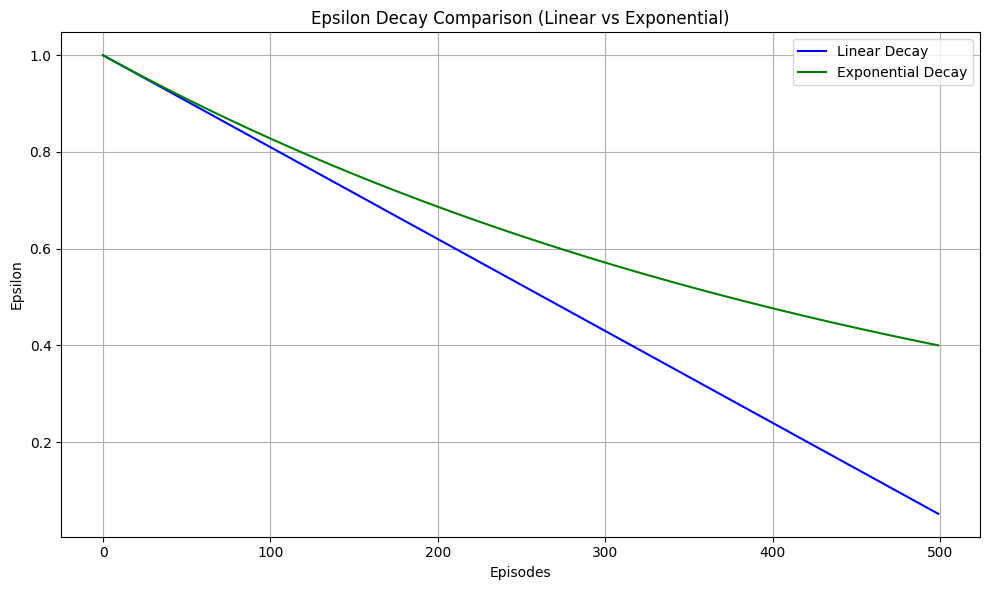

In [19]:
import matplotlib.pyplot as plt

# Define the linear epsilon function
def linear_epsilon(steps_done):
    return max(EPS_END, EPS_START - (EPS_START - EPS_END) * (steps_done / EPS_DECAY))

# Define the corrected exponential epsilon function
def exponential_epsilon(steps_done):
    return EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)

# Recalculate epsilon values using the defined functions
steps_done = np.arange(NUM_EPISODES)

linear_epsilons = [linear_epsilon(step) for step in steps_done]
exp_epsilons = [exponential_epsilon(step) for step in steps_done]

# Plotting both linear and exponential decay
plt.figure(figsize=(10, 6))
plt.plot(steps_done, linear_epsilons, label='Linear Decay', color='blue')
plt.plot(steps_done, exp_epsilons, label='Exponential Decay', color='green')
plt.title('Epsilon Decay Comparison (Linear vs Exponential)')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
def policy(observation: torch.Tensor, q_network: nn.Module, steps_done: int):
    sample = random.random()
    if sample < exponential_epsilon(steps_done):
        return np.random.randint(0, ACTION_DIM)
    else:
        with torch.no_grad():
            q_values = q_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

In [21]:
def save_model(policy_net, path="models/qmix.pt"):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    torch.save(policy_net.state_dict(), path)

# Reward Shaping

In [22]:
# Define shaping reward/penalty constants
SHAPING_SUCCESSFUL_PICKUP_BONUS = 1
SHAPING_SUCCESSFUL_DELIVERY_BONUS = 10
SHAPING_LATE_DELIVERY_PENALTY = -1  # Additional penalty for being late, on top of env's
SHAPING_WASTED_PICKUP_PENALTY = -1 # Tried to pick from an empty spot or already carrying
SHAPING_WASTED_DROP_PENALTY = -1   # Tried to drop when not carrying

def reward_shaping(global_r, prev_state, current_state, actions_taken):
    """
    Shapes the global reward 'global_r' to produce individual rewards.
    Requires prev_state to infer agent-specific events.

    Args:
        global_r (float): The global reward from the environment for the current step (s -> s').
        prev_state (dict): The state 's' before actions_taken.
        current_state (dict): The state 's'' after actions_taken.
        actions_taken (list): List of actions [action_agent_0, action_agent_1, ...]
                              taken by agents that led from prev_state to current_state.
                              Each action is (move_idx, package_op_idx).

    Returns:
        list: A list of shaped rewards, one for each agent.
    """
    
    individual_rewards = [0.0] * NUM_AGENTS

    # Initialize individual rewards. Option A: Each gets the global reward.
    for i in range(NUM_AGENTS):
        individual_rewards[i] = global_r

    # For easier access to package details by ID from the previous state
    prev_packages_dict = {pkg[0]: pkg for pkg in prev_state['packages']}
    current_time = current_state['time_step']

    for i in range(NUM_AGENTS):
        print(f"Agent {i} is taking action {actions_taken[i]}")
        agent_action = actions_taken[i]
        package_op = agent_action[1]  # 0: None, 1: Pick, 2: Drop

        prev_robot_info = prev_state['robots'][i]
        current_robot_info = current_state['robots'][i]

        prev_carrying_id = prev_robot_info[2]
        current_carrying_id = current_robot_info[2]

        # 1. Shaping for PICKUP attempts
        if package_op == 1:  # Agent attempted to PICKUP
            if prev_carrying_id == 0 and current_carrying_id != 0:
                # Successfully picked up a package
                individual_rewards[i] += SHAPING_SUCCESSFUL_PICKUP_BONUS
            elif prev_carrying_id != 0 : # Tried to pick up while already carrying
                individual_rewards[i] += SHAPING_WASTED_PICKUP_PENALTY
            elif prev_carrying_id == 0 and current_carrying_id == 0:
                # Attempted pickup but failed to pick up anything.
                # Check if there was a package at the robot's previous location.
                robot_prev_pos = (prev_robot_info[0], prev_robot_info[1])
                package_was_available = False
                for pkg_id, sr, sc, tr, tc, st, dl in prev_state['packages']:
                    if (sr, sc) == robot_prev_pos:
                        # A package was at the location. Maybe another agent took it, or it was a valid attempt.
                        # No penalty here, or a smaller one for contention if desired.
                        package_was_available = True
                        break
                if not package_was_available:
                    # Tried to pick up from a location with no package
                    individual_rewards[i] += SHAPING_WASTED_PICKUP_PENALTY


        # 2. Shaping for DROP attempts
        elif package_op == 2:  # Agent attempted to DROP
            if prev_carrying_id != 0 and current_carrying_id == 0:
                # Successfully delivered/dropped a package
                individual_rewards[i] += SHAPING_SUCCESSFUL_DELIVERY_BONUS
                
                # Check for timeliness if it was a delivery (package removed from list)
                delivered_pkg_id = prev_carrying_id
                # Check if this package ID is no longer in current_state['packages']
                # (indicating it was a final delivery to target)
                is_final_delivery = True
                for pkg_data in current_state['packages']:
                    if pkg_data[0] == delivered_pkg_id:
                        is_final_delivery = False # Package still exists, maybe dropped not at target
                        break
                
                if is_final_delivery and delivered_pkg_id in prev_packages_dict:
                    pkg_deadline = prev_packages_dict[delivered_pkg_id][6]
                    if current_time > pkg_deadline:
                        individual_rewards[i] += SHAPING_LATE_DELIVERY_PENALTY
            elif prev_carrying_id == 0:
                # Tried to drop when not carrying anything
                individual_rewards[i] += SHAPING_WASTED_DROP_PENALTY
                
    return individual_rewards

prev_state = {
    'robots': [
        (2, 2, 0),  # agent 0 at (2,2), not carrying
        (3, 3, 1),  # agent 1 at (3,3), carrying package 1
        (4, 4, 0),  # agent 2 at (4,4), not carrying
        (5, 5, 0),  # agent 3 at (5,5), not carrying
        (6, 6, 0),  # agent 4 at (6,6), not carrying
    ],
    'packages': [
        (1, 2, 2, 5, 5, 0, 10),  # id, start_r, start_c, target_r, target_c, start_time, deadline
        (2, 3, 3, 4, 4, 0, 10),  # id, start_r, start_c, target_r, target_c, start_time, deadline
        (3, 4, 4, 3, 3, 0, 10),  # id, start_r, start_c, target_r, target_c, start_time, deadline
        (4, 5, 5, 2, 2, 0, 10),  # id, start_r, start_c, target_r, target_c, start_time, deadline
    ],
    'time_step': 5
}
current_state = {
    'robots': [
        (2, 2, 1),  # agent 0 at (2,2), now carrying package 1 (picked up)
        (5, 5, 0),  # agent 1 at (5,5), not carrying (delivered)
        (4, 4, 0),  # agent 2 at (4,4), not carrying
        (3, 3, 0),  # agent 3 at (3,3), not carrying
        (2, 2, 0),  # agent 4 at (2,2), not carrying
    ],
    'packages': [
        # Package 1 is gone, delivered!
        (2, 3, 3, 4, 4, 0, 10),  # id, start_r, start_c, target_r, target_c, start_time, deadline
        (3, 4, 4, 3, 3, 0, 10),  # id, start_r, start_c, target_r, target_c, start_time, deadline
        (4, 5, 5, 2, 2, 0, 10),  # id, start_r, start_c, target_r, target_c, start_time, deadline
    ],
    'time_step': 6
}
actions = [
    (0, 1),  # agent 0: stay, PICKUP
    (0, 2),  # agent 1: stay, DROP
    (0, 0),  # agent 2: stay, None
    (3, 2),  # agent 3: move right, PICKUP
    (2, 1),  # agent 4: move up, PICKUP
]

global_r = 5.0

rewards = reward_shaping(global_r, prev_state, current_state, actions)
print("Shaped rewards:", rewards)

Agent 0 is taking action (0, 1)
Agent 1 is taking action (0, 2)
Agent 2 is taking action (0, 0)
Agent 3 is taking action (3, 2)
Agent 4 is taking action (2, 1)
Shaped rewards: [6.0, 15.0, 5.0, 4.0, 4.0]


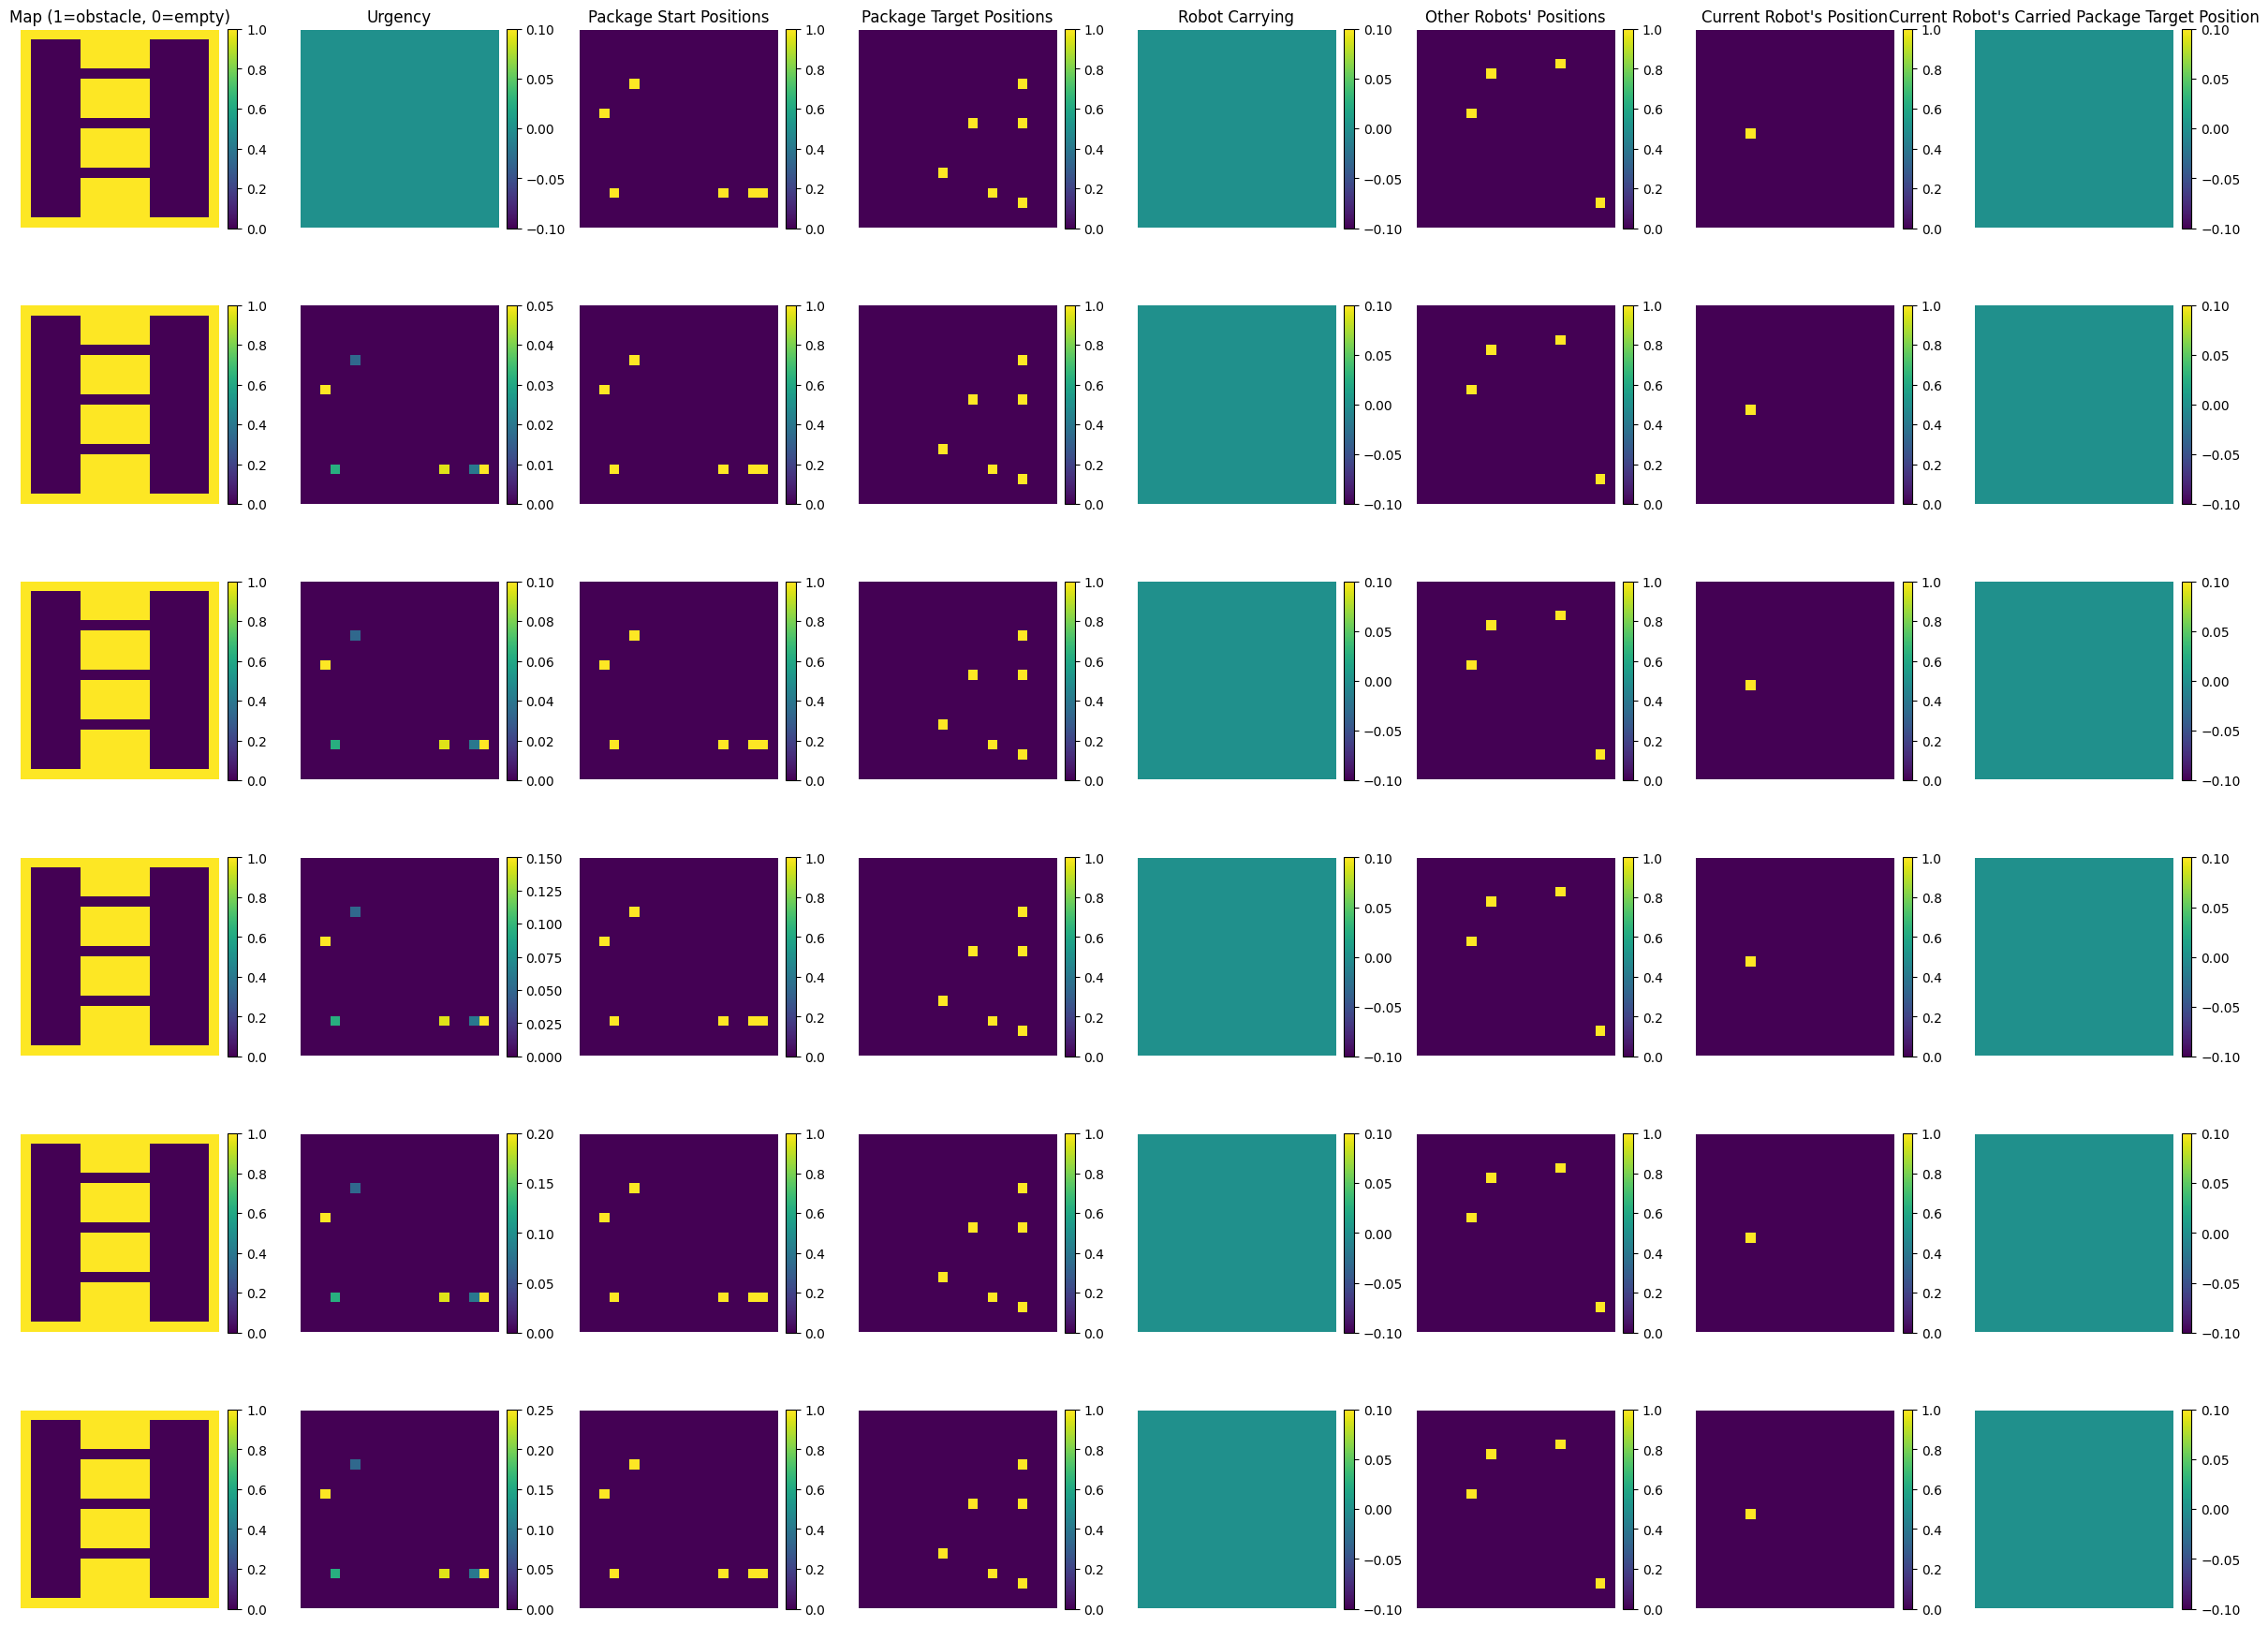

In [23]:
import matplotlib.pyplot as plt

# Khởi tạo môi trường
test_env = Environment("map1.txt")
state = test_env.reset()

def plot_state(state):
    def get_persistent_packages(env):
        return {
            p.package_id: {
                'id': p.package_id,
                'start_pos': p.start,
                'target_pos': p.target,
                'start_time': p.start_time,
                'deadline': p.deadline,
                'status': p.status
            }
            for p in env.packages if p.status != 'delivered'
        }

    current_robot_idx = 2
    n_robots = len(state['robots'])
    actions = [(3, 2)] * n_robots  # All agents stay in place

    # Lưu lại tensor của từng bước
    tensors = []
    states = []
    persistent_pkgs = []

    for step in range(6):  # 0 (initial) + 5 steps
        pkgs = get_persistent_packages(test_env)
        tensor = convert_state(state, pkgs, current_robot_idx=current_robot_idx)
        tensors.append(tensor)
        states.append(state)
        persistent_pkgs.append(pkgs)
        if step < 5:
            state, reward, done, infos = test_env.step(actions)

    channel_names = [
        "Map (1=obstacle, 0=empty)",
        "Urgency",
        "Package Start Positions",
        "Package Target Positions",
        "Robot Carrying",
        "Other Robots' Positions",
        "Current Robot's Position",
        "Current Robot's Carried Package Target Position",
    ]

    n_channels = tensors[0].shape[0]
    fig, axes = plt.subplots(6, n_channels, figsize=(3*n_channels, 3*6))

    for step in range(6):
        for i in range(n_channels):
            ax = axes[step, i]
            im = ax.imshow(tensors[step][i], cmap='viridis', interpolation='nearest')
            if step == 0:
                ax.set_title(channel_names[i])
            if i == 0:
                ax.set_ylabel(f"Step {step}", fontsize=12)
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


# Initialize

In [24]:
env = Environment(map_file=MAP_FILE,
                  n_robots=NUM_AGENTS, 
                  n_packages=N_PACKAGES,
                  move_cost=MOVE_COST,
                  delivery_reward=DELIVERY_REWARD,
                  delay_reward=DELAY_REWARD,
                  seed=SEED,
                  max_time_steps=MAX_TIME_STEPS)
env.reset()

{'time_step': 0,
 'map': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'robots': [(6, 9, 0), (2, 5, 0), (2, 3, 0), (2, 9, 0), (9, 3, 0)],
 'packages': [(1, 7, 3, 2, 5, 0, 36),
  (2, 5, 6, 9, 8, 0, 32),
  (3, 5, 3, 7, 5, 0, 16),
  (4, 3, 3, 9, 7, 0, 18),
  (5, 3, 7, 5, 8, 0, 30),
  (6, 3, 8, 2, 9, 0, 28)]}

In [25]:
class QMixTrainer:
    def __init__(self, env, lr=LR, weight_decay=WEIGHT_DECAY, gamma=GAMMA, tau=TAU, gradient_clipping=GRADIENT_CLIPPING):
        self.env = env
        OBS_DIM = (8, env.n_rows, env.n_cols ) # 7 channels: map, urgency, start position, target position, robot carrying, robot position, current robot position
        STATE_DIM = (6, env.n_rows, env.n_cols) # 6 channels: map, urgency, start position, target position, robot carrying, robot position
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Initialize LabelEncoders for actions
        self.le_move = LabelEncoder()
        self.le_move.fit(['S', 'L', 'R', 'U', 'D']) # Stay, Left, Right, Up, Down
        self.le_pkg_op = LabelEncoder()
        self.le_pkg_op.fit(['0', '1', '2']) # 0: None, 1: Pickup, 2: Drop
        self.NUM_MOVE_ACTIONS = len(self.le_move.classes_) # 5
        self.NUM_PKG_OPS = len(self.le_pkg_op.classes_) # 3
        
        # Network
        self.agent_network = AgentNetwork(OBS_DIM, ACTION_DIM).to(self.device)
        self.mixing_network = MixingNetwork(STATE_DIM, NUM_AGENTS, MIXING_DIM).to(self.device)
        
        # Target networks
        self.target_agent_network = AgentNetwork(OBS_DIM, ACTION_DIM).to(self.device)
        self.target_agent_network.load_state_dict(self.agent_network.state_dict())
        self.target_mixing_network = MixingNetwork(STATE_DIM, NUM_AGENTS, MIXING_DIM).to(self.device)
        self.target_mixing_network.load_state_dict(self.mixing_network.state_dict())
        
        self.buffer = ReplayBuffer(capacity=MAX_REPLAY_BUFFER_SIZE, num_agents=NUM_AGENTS, obs_shape=OBS_DIM, state_shape=STATE_DIM, device=self.device)
        self.lr = lr
        self.weight_decay = weight_decay
        self.gamma = gamma
        self.tau = tau
        self.gradient_clipping = gradient_clipping
        
        # Persistent packages to track the package id and the target position
        self.persistent_packages = {}

        self.update_targets(1.0)  # Hard update at start

        self.agent_optimizer = optim.Adam(self.agent_network.parameters(), lr=lr, weight_decay=weight_decay)
        self.mixing_optimizer = optim.Adam(self.mixing_network.parameters(), lr=lr, weight_decay=weight_decay)
        
    def _update_persistent_packages(self, current_env_state): 
        """
        Updates self.persistent_packages based on the current environment state.
        - current_env_state: The state dictionary from env.step() or env.reset().
        """
        # 1. Add newly appeared packages to persistent_packages if not already tracked
        if 'packages' in current_env_state and current_env_state['packages'] is not None:
            for pkg_tuple in current_env_state['packages']:
                pkg_id = pkg_tuple[0]
                if pkg_id not in self.persistent_packages:
                    self.persistent_packages[pkg_id] = {
                        'id': pkg_id,
                        'start_pos': (pkg_tuple[1] - 1, pkg_tuple[2] - 1),
                        'target_pos': (pkg_tuple[3] - 1, pkg_tuple[4] - 1),
                        'start_time': pkg_tuple[5],
                        'deadline': pkg_tuple[6],
                        'status': 'waiting'
                    }

        # 2. Get current robot carrying info
        current_carried_pkg_ids_set = set()
        if 'robots' in current_env_state and current_env_state['robots'] is not None:
            for r_idx, r_data in enumerate(current_env_state['robots']):
                carried_id = r_data[2] # (pos_x+1, pos_y+1, carrying_package_id)
                if carried_id != 0:
                    current_carried_pkg_ids_set.add(carried_id)

        packages_to_remove_definitively = []

        # 3. Update package status
        for pkg_id, pkg_data in list(self.persistent_packages.items()):
            original_status_in_tracker = pkg_data['status']

            if pkg_id in current_carried_pkg_ids_set:
                # If currently being carried by any robot in current_env_state, set to 'in_transit'
                self.persistent_packages[pkg_id]['status'] = 'in_transit'
            else:
                # Package is NOT being carried in current_env_state
                if original_status_in_tracker == 'in_transit':
                    # This package WAS 'in_transit' (according to our tracker)
                    # and is now NOT carried in current_env_state.
                    # Given the env.py logic, this means it MUST have been delivered correctly.
                    packages_to_remove_definitively.append(pkg_id)
                # If original_status_in_tracker was 'waiting' and it's still not carried,
                # its status remains 'waiting'. No change needed to start_pos or status here.
                pass

        # 4. Remove packages that were successfully delivered
        for pkg_id_to_remove in packages_to_remove_definitively:
            if pkg_id_to_remove in self.persistent_packages:
                del self.persistent_packages[pkg_id_to_remove]


    def update_targets(self, tau=None):
        if tau is None:
            tau = self.tau
        # Soft update
        for target_param, param in zip(self.target_agent_network.parameters(), self.agent_network.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.target_mixing_network.parameters(), self.mixing_network.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def select_action(self, obs, eps):
        # obs_batch: (C, H, W)
        if obs is not isinstance(obs, torch.Tensor) and isinstance(obs, np.ndarray):
            obs = torch.from_numpy(obs).float().to(self.device)
        if np.random.rand() < eps:
            action = np.random.randint(0, ACTION_DIM)
        else:
            with torch.no_grad():
                q_values = self.agent_network(obs)
                action = torch.argmax(q_values, dim=1).item()
        return action

    def train_step(self, batch_size):
        if not self.buffer.can_sample(batch_size):
            return None

        batch_states, batch_next_states, batch_obs, batch_next_obs\
        , batch_actions, batch_total_rewards, batch_dones = \
        self.buffer.sample(batch_size)

        # batch_obs: (B, N, C, H, W)
        # batch_actions: (B, N)
        # batch_rewards: (B, 1)
        # batch_next_obs: (B, N, C, H, W)
        # batch_states: (B, C, H, W)
        # batch_next_states: (B, C, H, W)
        # batch_dones: (B, 1)

        B, N, C, H, W = batch_obs.shape
        
        reward_tot = batch_total_rewards.squeeze()  # shape: (BATCH_SIZE,)
        dones = batch_dones.squeeze()               # shape: (BATCH_SIZE,)

        # Compute individual Q-values for each agent in current observation
        individual_q_values = torch.stack([self.agent_network(batch_obs[:, i]) for i in range(NUM_AGENTS)], dim=1)  # [BATCH_SIZE, num_agents, action_dim]
        # Compute Q-values of action that agent has taken
        chosen_q_values = torch.gather(individual_q_values, 2, batch_actions.unsqueeze(-1)).squeeze(-1) # [BATCH_SIZE, num_agents]

        # Compute Q_tot for the current state
        q_tot = self.mixing_network(chosen_q_values, batch_states)  # [BATCH_SIZE]
        
        # Compute target Q-values
        with torch.no_grad():
            # Compute individual Q-values for next observation
            next_individual_q_values = torch.stack([self.target_agent_network(batch_next_obs[:, i]) for i in range(NUM_AGENTS)], dim=1)  # [BATCH_SIZE, num_agents, action_dim]
            target_q_values = next_individual_q_values .max(dim=-1)[0]  # [BATCH_SIZE, num_agents]

            # Compute Q_tot for next state using mixing network
            next_q_tot = self.target_mixing_network(target_q_values, batch_next_states)  # [BATCH_SIZE]

        # Compute targets
        target_q_tot = reward_tot + self.gamma * (1 - dones) * next_q_tot  # (BATCH_SIZE, )
        
        # Loss
        loss = F.mse_loss(q_tot, target_q_tot.detach())

        # Optimize
        self.agent_optimizer.zero_grad()
        self.mixing_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.agent_network.parameters(), self.gradient_clipping)
        torch.nn.utils.clip_grad_norm_(self.mixing_network.parameters(), self.gradient_clipping)
        self.agent_optimizer.step()
        self.mixing_optimizer.step()

        # Soft update target networks
        self.update_targets(self.tau)

        return loss.item()


    def run_episode(self, eps):
        current_state_dict = self.env.reset()
        self.persistent_packages = {}
        self._update_persistent_packages(current_state_dict)
        done = False
        episode_reward = 0
        episode_loss = 0
        step_count = 0

        while not done:
            self.env.render_pygame()
            # Build per-agent observations
            actions = []
            observations = []
            env_actions = []
            
            for i in range(NUM_AGENTS):
                obs = convert_state(current_state_dict, self.persistent_packages, current_robot_idx=i)
                observations.append(obs)
                action = self.select_action(obs, eps)
                actions.append(action)
            next_observations = []
            prev_state_dict = current_state_dict
            prev_state = convert_state(prev_state_dict, self.persistent_packages)
            
            # Take actions and get next state
            for int_act in actions:
                move_idx = int_act % self.NUM_MOVE_ACTIONS
                pkg_op_idx = int_act // self.NUM_MOVE_ACTIONS

                # Ensure pkg_op_idx is within bounds
                if pkg_op_idx >= self.NUM_PKG_OPS:
                    print(f"Warning: Decoded pkg_op_idx {pkg_op_idx} is out of bounds for action {int_act}. Max is {self.NUM_PKG_OPS-1}. Defaulting to op index 0.")
                    pkg_op_idx = 0 # Default to the first package operation (e.g., 'None')
                
                move_str = self.le_move.inverse_transform([move_idx])[0]
                pkg_op_str = self.le_pkg_op.inverse_transform([pkg_op_idx])[0]
                env_actions.append((move_str, pkg_op_str))
                
                            
            current_state_dict, global_reward, done, _= self.env.step(env_actions)
            self._update_persistent_packages(current_state_dict)
            current_state = convert_state(current_state_dict, self.persistent_packages)
            
            # Build per-agent next observations
            for i in range(NUM_AGENTS):
                next_obs = convert_state(current_state_dict, self.persistent_packages, current_robot_idx=i)
                next_observations.append(next_obs)

            # Store in buffer
            self.buffer.add(
                    obs=observations,
                    next_obs=next_observations,
                    state=prev_state,
                    next_state=current_state,
                    actions=actions,
                    total_reward=global_reward,
                    done=done
                )

            episode_reward += global_reward
            step_count += 1

            # Training step
            loss = self.train_step(BATCH_SIZE)
            if loss is not None:
                episode_loss += loss


        return episode_reward, episode_loss / max(1, step_count)

Starting QMIX training...
Running for 500 episodes.
Episode 10/500 | Reward: 3.07 | Avg Loss: 99.8139 | Epsilon: 0.983
Episode 20/500 | Reward: 23.47 | Avg Loss: 85003.7639 | Epsilon: 0.964
Episode 30/500 | Reward: 3.41 | Avg Loss: 20327714.8646 | Epsilon: 0.945
Episode 40/500 | Reward: 93.46 | Avg Loss: 3306641676.1725 | Epsilon: 0.926
Episode 50/500 | Reward: 13.61 | Avg Loss: 57569308591.9200 | Epsilon: 0.907
Saving checkpoint at episode 50...
Episode 60/500 | Reward: 13.88 | Avg Loss: 9068176425.2800 | Epsilon: 0.888
Episode 70/500 | Reward: 3.54 | Avg Loss: 43404832584.9600 | Epsilon: 0.869
Episode 80/500 | Reward: 14.46 | Avg Loss: 100522285982.7200 | Epsilon: 0.850
Episode 90/500 | Reward: 23.51 | Avg Loss: 172732840163.8400 | Epsilon: 0.831
Episode 100/500 | Reward: -5.99 | Avg Loss: 136380233103.3600 | Epsilon: 0.812
Saving checkpoint at episode 100...
Episode 110/500 | Reward: 5.15 | Avg Loss: 243123971860.4800 | Epsilon: 0.793
Episode 120/500 | Reward: 4.50 | Avg Loss: 28580

Traceback (most recent call last):
  File "/tmp/ipykernel_805827/653296851.py", line 20, in <module>
    episode_reward, avg_episode_loss = trainer.run_episode(current_epsilon)
  File "/tmp/ipykernel_805827/3808378281.py", line 184, in run_episode
    self.env.render_pygame()
  File "/home/huy/Project/marl-delivery/env.py", line 377, in render_pygame
    exit()
NameError: name 'exit' is not defined


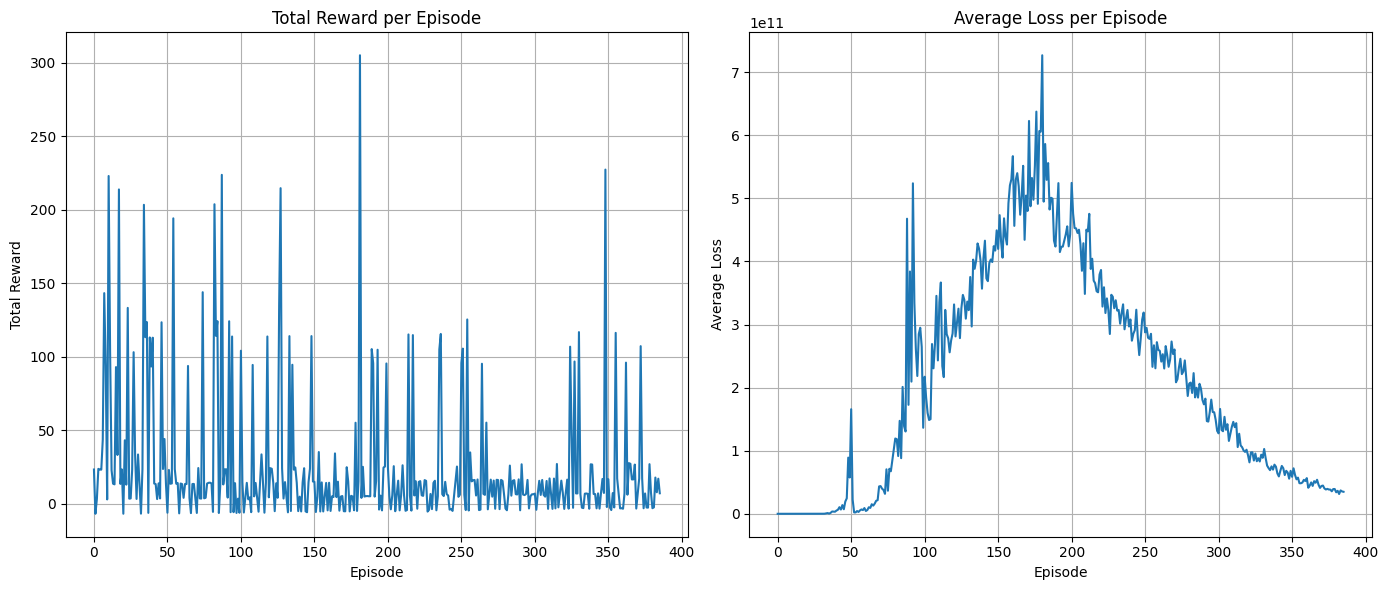

In [26]:
import pygame


trainer = QMixTrainer(env)

# Lists to store metrics for plotting
episode_rewards_history = []
episode_avg_loss_history = []

training_completed_successfully = False
print("Starting QMIX training...")
print(f"Running for {NUM_EPISODES} episodes.")

try:
    for episode_num in range(1, NUM_EPISODES + 1):
        # The exponential_epsilon function from in[16] expects 'steps_done'
        # Assuming 'steps_done' in that context refers to the number of episodes completed (0-indexed)
        current_epsilon = linear_epsilon(episode_num - 1) 
        
        episode_reward, avg_episode_loss = trainer.run_episode(current_epsilon)
        
        episode_rewards_history.append(episode_reward)
        episode_avg_loss_history.append(avg_episode_loss)
        
        if episode_num % 10 == 0 or episode_num == NUM_EPISODES: # Print every 10 episodes and the last one
            print(f"Episode {episode_num}/{NUM_EPISODES} | Reward: {episode_reward:.2f} | Avg Loss: {avg_episode_loss:.4f} | Epsilon: {current_epsilon:.3f}")

        # Optional: Periodic saving during training
        if episode_num % 50 == 0: # Example: Save every 50 episodes
            print(f"Saving checkpoint at episode {episode_num}...")
            save_model(trainer.agent_network, path=f"models/qmix_agent_ep{episode_num}.pt")
            save_model(trainer.mixing_network, path=f"models/qmix_mixer_ep{episode_num}.pt")
            
    training_completed_successfully = True

except KeyboardInterrupt:
    print("\nTraining interrupted by user (KeyboardInterrupt).")
    print("Saving current model state...")
    save_model(trainer.agent_network, path="models/qmix_agent_interrupted.pt")
    save_model(trainer.mixing_network, path="models/qmix_mixer_interrupted.pt")
    print("Models saved to _interrupted.pt files.")
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback for the exception
    print("Saving model due to exception...")
    save_model(trainer.agent_network, path="models/qmix_agent_exception.pt")
    save_model(trainer.mixing_network, path="models/qmix_mixer_exception.pt")
    print("Models saved to _exception.pt files.")
finally:
    print("\nTraining loop finished or was interrupted.")
    pygame.quit()
    
    # Plotting the results
    if episode_rewards_history: # Check if there's any data to plot
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(episode_rewards_history)
        plt.title('Total Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(episode_avg_loss_history)
        plt.title('Average Loss per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Average Loss')
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("No data recorded for plotting.")

if training_completed_successfully:
    print("\nTraining completed successfully.")
    print("Saving final model...")
    save_model(trainer.agent_network, path="models/qmix_agent_final.pt")
    save_model(trainer.mixing_network, path="models/qmix_mixer_final.pt")
    print("Final models saved.")

In [27]:
torch.save(trainer.agent_network.state_dict(), "/kaggle/working/qmix_agent.pt")
torch.save(trainer.mixing_network.state_dict(), "/kaggle/working/qmix_mixer.pt")

RuntimeError: Parent directory /kaggle/working does not exist.